In [1]:
import os
import sys
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import pickle
import torch
from torch import nn
import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks import ModelCheckpoint
from tqdm import tqdm

current_dir = os.path.join(Path().resolve())
# モジュールのあるパスを追加
sys.path.append(str(current_dir) + '/../train')

import model._models as models
import datamodule._datamodules as datamodules
import dataset._datasets as datasets
import route._routes as routes
import mylib.utils as ut
import mylib.config as conf

In [2]:
ROOT_PATH = os.path.dirname(os.path.dirname(os.path.abspath("__file__")))
# DF_PATH = os.path.join(ROOT_PATH, "data", "df_test.pickle")
DF_PATH = os.path.join(ROOT_PATH, "data", "df_5s_avg.pickle")
OUTPUT_DIR = os.path.join(ROOT_PATH, "out")
CONFIG_DIR = os.path.join(ROOT_PATH, "config")

In [3]:
def plot_route(y, y_hat):
    plt.figure(figsize=(4, 10))
    plt.plot(y[0, :, 0], y[0, :, 1], marker="o")
    plt.plot(y_hat[0, :, 0], y_hat[0, :, 1], marker="x")
    plt.xlim(0, 3.5)
    plt.ylim(0, 11)
    plt.show()

In [4]:
def plot_route2(x, y, y_hat):
    # 2つのルートをプロット
    fig, ax = plt.subplots(1, 2)
    ax[0].plot(x[0, :, 3], x[0, :, 4], marker="o")
    ax[1].plot(y[0, :, 0], y[0, :, 1], marker="o", label="true")
    ax[1].plot(y_hat[0, :, 0], y_hat[0, :, 1], marker="x", label="pred")
    ax[1].set_xlim(0, 3.5)
    ax[1].set_ylim(0, 11)
    ax[1].legend()
    plt.show()

In [5]:
def get_random_noise(mean, std, shape):
    # ランダムノイズを生成
    random_noise = torch.normal(mean=mean, std=std, size=shape)
    # random_noise = torch.empty(x.shape[0], x.shape[1]).uniform_(-0.5, 0.5)
    return random_noise

In [6]:
# log_dir = Path(r"C:\Users\hal\Documents\lab\abci\out\lightning_logs\reuslt\1-2024-09-26-01-42-3ax_zeros")
# log_dir = Path(r"C:\Users\hal\Documents\lab\abci\out\lightning_logs\reuslt\2-2024-10-05-08-20-3ax_distance")
# log_dir = Path(r"C:\Users\hal\Documents\lab\abci\out\lightning_logs\reuslt\3-2024-09-28-14-23-3ax_route")
# log_dir = Path(r"C:\Users\hal\Documents\lab\abci\out\lightning_logs\reuslt\4-2024-10-09-22-42-3ax_route_diff")
# log_dir = Path(r"C:\Users\hal\Documents\lab\abci\out\lightning_logs\reuslt\5-2024-10-09-22-34-2ax_zeros_abci")
# log_dir = Path(r"C:\Users\hal\Documents\lab\abci\out\lightning_logs\reuslt\6-2024-10-09-22-34-2ax_distance_abci")
# log_dir = Path(r"C:\Users\hal\Documents\lab\abci\out\lightning_logs\reuslt\7-2024-10-09-22-34-2ax_route_abci")
# log_dir = Path(r"C:\Users\hal\Documents\lab\abci\out\lightning_logs\reuslt\8-2024-10-09-22-34-2ax_route_diff_abci")

log_dirs = [
    Path(r"C:\Users\hal\Documents\lab\abci\out\lightning_logs\reuslt\1-2024-09-26-01-42-3ax_zeros"),
    Path(r"C:\Users\hal\Documents\lab\abci\out\lightning_logs\reuslt\2-2024-10-05-08-20-3ax_distance"),
    Path(r"C:\Users\hal\Documents\lab\abci\out\lightning_logs\reuslt\3-2024-09-28-14-23-3ax_route"),
    Path(r"C:\Users\hal\Documents\lab\abci\out\lightning_logs\reuslt\4-2024-10-09-22-42-3ax_route_diff"),
    Path(r"C:\Users\hal\Documents\lab\abci\out\lightning_logs\reuslt\5-2024-10-09-22-34-2ax_zeros_abci"),
    Path(r"C:\Users\hal\Documents\lab\abci\out\lightning_logs\reuslt\6-2024-10-09-22-34-2ax_distance_abci"),
    Path(r"C:\Users\hal\Documents\lab\abci\out\lightning_logs\reuslt\7-2024-10-09-22-34-2ax_route_abci"),
    Path(r"C:\Users\hal\Documents\lab\abci\out\lightning_logs\reuslt\8-2024-10-09-22-34-2ax_route_diff_abci"),
    Path(r"C:\Users\hal\Documents\lab\abci\out\lightning_logs\reuslt\9-2024-10-25-22-47-2ax_noise_zeros_abci"),
    Path(r"C:\Users\hal\Documents\lab\abci\out\lightning_logs\reuslt\10-2024-10-25-22-55-2ax_noise_distance_abci"),
    Path(r"C:\Users\hal\Documents\lab\abci\out\lightning_logs\reuslt\11-2024-10-25-22-47-2ax_noise_route_abci"),
    Path(r"C:\Users\hal\Documents\lab\abci\out\lightning_logs\reuslt\12-2024-10-25-22-47-2ax_noise_route_diff_abci")
]




In [7]:
def eval(log_dir, add_noise=False):

    cp_path = os.path.join(log_dir, "cp/best_loss_fold.ckpt")
    config_path = os.path.join(log_dir, "config.yaml")

    ut.fix_seeds(0)
    df = pickle.load(open(DF_PATH, "rb"))
    config = conf.from_yaml(config_path)

    # 各種初期化
    model = models.get_model_with_checkpoint(config["model"], cp_path)
    route_gen = routes.get_route_generator(config["route"])
    dataset = datasets.get_dataset(config["dataset"])
    dm = datamodules.get_dm(config["dm"])

    dataset.set_route(df, route_gen)
    dm.setDataset(dataset)


    model.eval()
    loss_list = []
    dist_list = []

    # シーケンスバーでループ

    

    for i in tqdm(range(len(dm.test_dataset))):
        # batch = dm.train_dataset[i]
        # batch = dm.val_dataset[i]
        batch = dm.test_dataset[i]

        x, y = batch
        x = x.unsqueeze(0).cuda()
        y = y.unsqueeze(0).cuda()

        if add_noise:
            mean = 0.0  # 平均
            std = 0.381  # 標準偏差
            x[:, :, 0] += get_random_noise(mean, std, (x.shape[0], x.shape[1])).cuda()
            x[:, :, 1] += get_random_noise(mean, std, (x.shape[0], x.shape[1])).cuda()
            x[:, :, 2] += get_random_noise(mean, std, (x.shape[0], x.shape[1])).cuda()

        
        y_hat = model(x)

        loss = nn.functional.mse_loss(y_hat, y)
        loss_list.append(loss.item())

        # print(loss.item())

        x = x.cpu().detach().numpy()
        y_hat = y_hat.cpu().detach().numpy()
        y = y.cpu().detach().numpy()
        # plot_route2(x, y, y_hat)
        # plot_route(y, y_hat)

        dist_errors = np.linalg.norm(y - y_hat, axis=-1)
        # print(dist_errors)
        dist_mean = np.mean(dist_errors)
        
        dist_list.append(dist_mean)  
        # print(dist_mean)
        

    # plt.plot(loss_list)
    # plt.show()

    # plt.plot(dist_list)
    # plt.show()

    # avg = sum(loss_list) / len(loss_list)
    # print(avg)


    print(config["fname"])
    print(f'min: {min(dist_list)}')
    print(f'max: {max(dist_list)}')
    print(f'avg: {sum(dist_list) / len(dist_list)}')
    return dist_list


In [8]:
dist_list_list = []

for log_dir in log_dirs[:]:
    dist_list = eval(log_dir, False)
    dist_list_list.append(dist_list)
    print(np.shape(dist_list_list))

  0%|          | 0/2000 [00:00<?, ?it/s]c:\Users\hal\Documents\lab\abci\env\Lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)
100%|██████████| 2000/2000 [00:35<00:00, 56.36it/s]


3ax_zeros
min: 0.07677929103374481
max: 0.31494084000587463
avg: 0.13036597901955246
(1, 2000)


100%|██████████| 2000/2000 [00:35<00:00, 56.12it/s]


3ax_distance
min: 0.07565263658761978
max: 0.3281823396682739
avg: 0.13502049499377608
(2, 2000)


100%|██████████| 2000/2000 [00:35<00:00, 55.70it/s]


3ax_route
min: 0.06940124928951263
max: 0.21481585502624512
avg: 0.11164074742421508
(3, 2000)


100%|██████████| 2000/2000 [00:38<00:00, 52.01it/s]


3ax_route_diff
min: 0.08110387623310089
max: 0.2963656783103943
avg: 0.13566456208750605
(4, 2000)


100%|██████████| 2000/2000 [00:38<00:00, 51.80it/s]


2ax_zeros_abci
min: 0.1834789216518402
max: 1.2526507377624512
avg: 0.5049156491160393
(5, 2000)


100%|██████████| 2000/2000 [00:41<00:00, 48.06it/s]


2ax_distance_abci
min: 0.17922146618366241
max: 1.2344465255737305
avg: 0.5133560737594962
(6, 2000)


100%|██████████| 2000/2000 [00:42<00:00, 47.53it/s]


2ax_route_abci
min: 0.08366793394088745
max: 0.6842378377914429
avg: 0.16420056788995863
(7, 2000)


100%|██████████| 2000/2000 [00:40<00:00, 49.53it/s]


2ax_route_diff_abci
min: 0.11048261821269989
max: 0.7900567054748535
avg: 0.2547927122339606
(8, 2000)


100%|██████████| 2000/2000 [00:39<00:00, 50.23it/s]


2ax_noise_zeros_abci
min: 0.3098847270011902
max: 1.7408111095428467
avg: 0.8316827901154756
(9, 2000)


100%|██████████| 2000/2000 [00:41<00:00, 48.63it/s]


2ax_noise_distance_abci
min: 0.3346427381038666
max: 1.7853463888168335
avg: 0.8408606915920973
(10, 2000)


100%|██████████| 2000/2000 [00:39<00:00, 50.09it/s]


2ax_noise_route_abci
min: 0.0917511135339737
max: 0.9895612597465515
avg: 0.2112714222855866
(11, 2000)


100%|██████████| 2000/2000 [00:36<00:00, 54.12it/s]

2ax_noise_route_diff_abci
min: 0.13861027359962463
max: 1.6499181985855103
avg: 0.34161598305404184
(12, 2000)


In [9]:
dist_list_list_noise = []

for log_dir in log_dirs[:]:
    dist_list = eval(log_dir, True)
    dist_list_list_noise.append(dist_list)
    print(np.shape(dist_list_list_noise))

100%|██████████| 2000/2000 [00:35<00:00, 55.84it/s]


3ax_zeros
min: 0.27274447679519653
max: 1.598693609237671
avg: 0.7671359070837498
(1, 2000)


100%|██████████| 2000/2000 [00:35<00:00, 55.57it/s]


3ax_distance
min: 0.22814007103443146
max: 1.4999122619628906
avg: 0.7443014196231961
(2, 2000)


100%|██████████| 2000/2000 [00:36<00:00, 54.93it/s]


3ax_route
min: 0.12240661680698395
max: 0.6233546137809753
avg: 0.24089019164443015
(3, 2000)


100%|██████████| 2000/2000 [00:36<00:00, 55.22it/s]


3ax_route_diff
min: 0.17294374108314514
max: 1.1541101932525635
avg: 0.49992306471616027
(4, 2000)


100%|██████████| 2000/2000 [00:36<00:00, 55.23it/s]


2ax_zeros_abci
min: 0.4410872459411621
max: 1.981175184249878
avg: 1.138370225697756
(5, 2000)


100%|██████████| 2000/2000 [00:36<00:00, 54.96it/s]


2ax_distance_abci
min: 0.3798093795776367
max: 1.933810830116272
avg: 1.027376873165369
(6, 2000)


100%|██████████| 2000/2000 [00:36<00:00, 54.87it/s]


2ax_route_abci
min: 0.12234294414520264
max: 0.9569490551948547
avg: 0.2553127286657691
(7, 2000)


100%|██████████| 2000/2000 [00:36<00:00, 54.58it/s]


2ax_route_diff_abci
min: 0.16284553706645966
max: 1.4160724878311157
avg: 0.4281946353018284
(8, 2000)


100%|██████████| 2000/2000 [00:36<00:00, 54.46it/s]


2ax_noise_zeros_abci
min: 0.42507362365722656
max: 1.8561890125274658
avg: 1.0480382432490587
(9, 2000)


100%|██████████| 2000/2000 [00:36<00:00, 54.27it/s]


2ax_noise_distance_abci
min: 0.3925382196903229
max: 1.7541828155517578
avg: 0.9559033892303705
(10, 2000)


100%|██████████| 2000/2000 [00:37<00:00, 53.97it/s]


2ax_noise_route_abci
min: 0.09815046936273575
max: 1.1510378122329712
avg: 0.2354048658758402
(11, 2000)


100%|██████████| 2000/2000 [00:38<00:00, 52.13it/s]

2ax_noise_route_diff_abci
min: 0.15521864593029022
max: 1.4803498983383179
avg: 0.3804554409608245
(12, 2000)


In [61]:
def create_boxplot(t, data, title):
    # 箱ひげ図を作成
    plt.boxplot(data[t-1: t+2], vert=False, showmeans=True, showfliers=False, labels=["mf", "mf+d", "mf+dydx"], widths=0.5)
    # plt.ylim(0, 1.85)
    plt.xlim(0, 1.85)
    plt.title(title)
    plt.show()

C:\TEMP\ipykernel_15840\2730377337.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data[t-1: t+2], vert=False, showmeans=True, showfliers=False, labels=["mf", "mf+d", "mf+dydx"], widths=0.5)


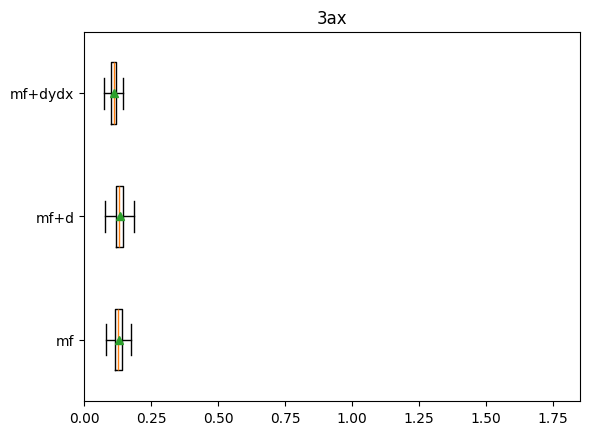

C:\TEMP\ipykernel_15840\2730377337.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data[t-1: t+2], vert=False, showmeans=True, showfliers=False, labels=["mf", "mf+d", "mf+dydx"], widths=0.5)


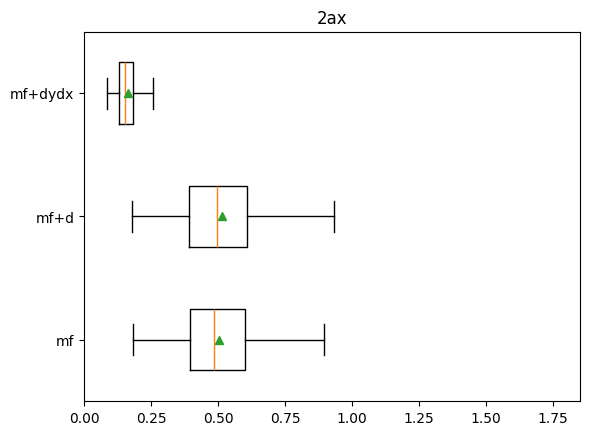

C:\TEMP\ipykernel_15840\2730377337.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data[t-1: t+2], vert=False, showmeans=True, showfliers=False, labels=["mf", "mf+d", "mf+dydx"], widths=0.5)


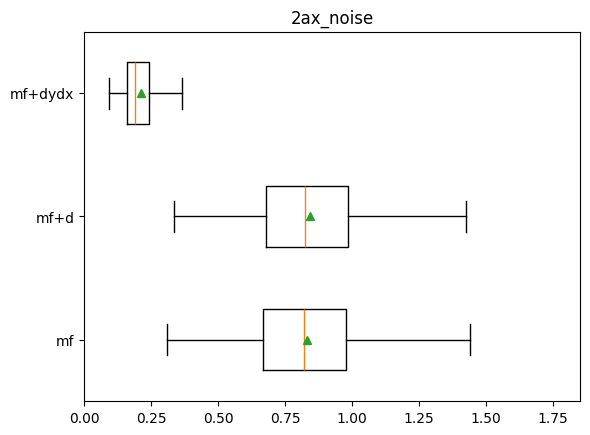

C:\TEMP\ipykernel_15840\2730377337.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data[t-1: t+2], vert=False, showmeans=True, showfliers=False, labels=["mf", "mf+d", "mf+dydx"], widths=0.5)


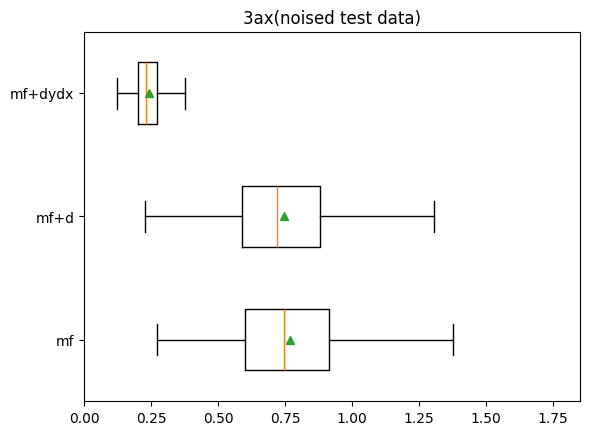

C:\TEMP\ipykernel_15840\2730377337.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data[t-1: t+2], vert=False, showmeans=True, showfliers=False, labels=["mf", "mf+d", "mf+dydx"], widths=0.5)


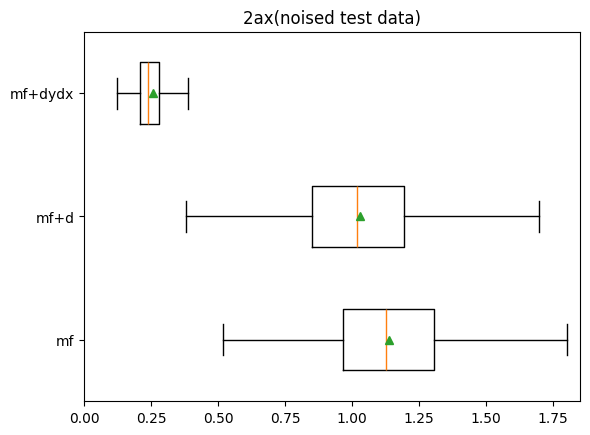

C:\TEMP\ipykernel_15840\2730377337.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data[t-1: t+2], vert=False, showmeans=True, showfliers=False, labels=["mf", "mf+d", "mf+dydx"], widths=0.5)


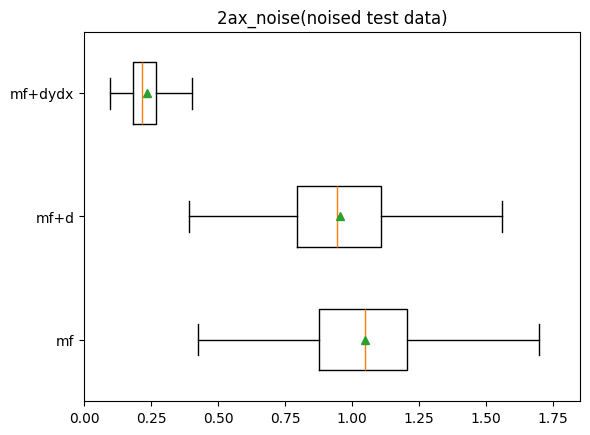

In [62]:
create_boxplot(1, dist_list_list, "3ax")
create_boxplot(5, dist_list_list, "2ax")
create_boxplot(9, dist_list_list, "2ax_noise")


create_boxplot(1, dist_list_list_noise, "3ax(noised test data)")
create_boxplot(5, dist_list_list_noise, "2ax(noised test data)")
create_boxplot(9, dist_list_list_noise, "2ax_noise(noised test data)")

In [63]:
def fig_data(log_dir, add_noise=False):

    cp_path = os.path.join(log_dir, "cp/best_loss_fold.ckpt")
    config_path = os.path.join(log_dir, "config.yaml")

    ut.fix_seeds(0)
    df = pickle.load(open(DF_PATH, "rb"))
    config = conf.from_yaml(config_path)

    # 各種初期化
    model = models.get_model_with_checkpoint(config["model"], cp_path)
    route_gen = routes.get_route_generator(config["route"])
    dataset = datasets.get_dataset(config["dataset"])
    dm = datamodules.get_dm(config["dm"])

    dataset.set_route(df, route_gen)
    dm.setDataset(dataset)


    model.eval()
    loss_list = []
    dist_list = []

    i = 212

    batch = dm.test_dataset[i]

    x, y = batch
    x = x.unsqueeze(0).cuda()
    y = y.unsqueeze(0).cuda()

    if add_noise:
        mean = 0.0  # 平均
        std = 0.381  # 標準偏差
        x[:, :, 0] += get_random_noise(mean, std, (x.shape[0], x.shape[1])).cuda()
        x[:, :, 1] += get_random_noise(mean, std, (x.shape[0], x.shape[1])).cuda()
        x[:, :, 2] += get_random_noise(mean, std, (x.shape[0], x.shape[1])).cuda()

    
    y_hat = model(x)

    loss = nn.functional.mse_loss(y_hat, y)
    loss_list.append(loss.item())


    x = x.cpu().detach().numpy()
    y_hat = y_hat.cpu().detach().numpy()
    y = y.cpu().detach().numpy()

    return x, y, y_hat

In [64]:
fig_datas = []
fig_datas_noise = []
for i, log_dir in enumerate(log_dirs[:]):
    print(i)
    fig_datas.append(fig_data(log_dir, False))
    fig_datas_noise.append(fig_data(log_dir, True))


0
1
2
3
4
5
6
7
8
9
10
11


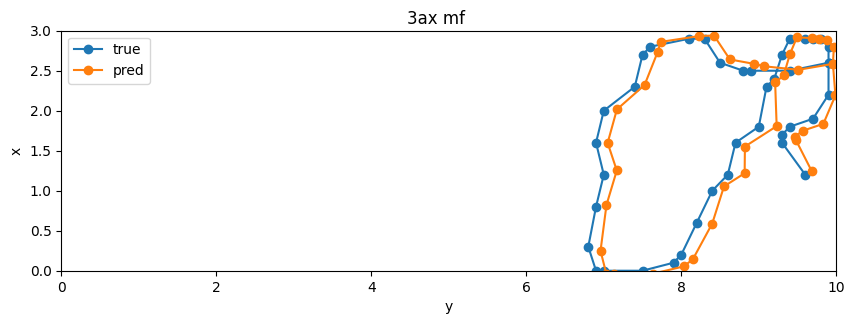

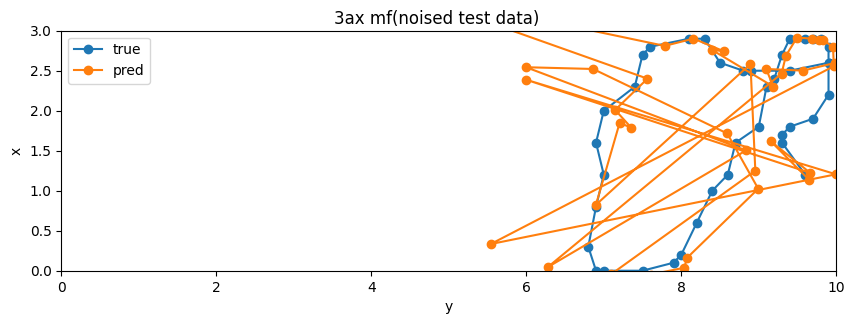

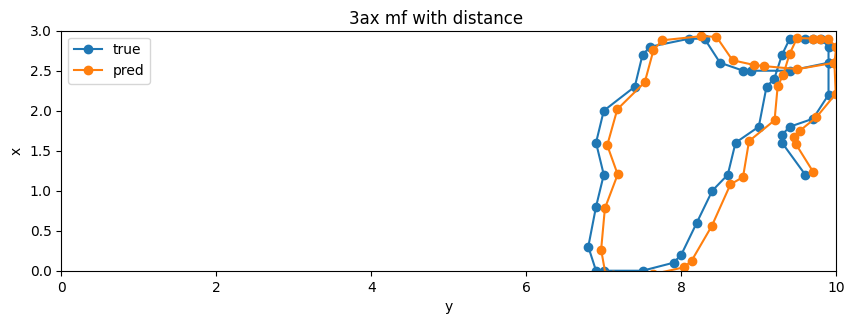

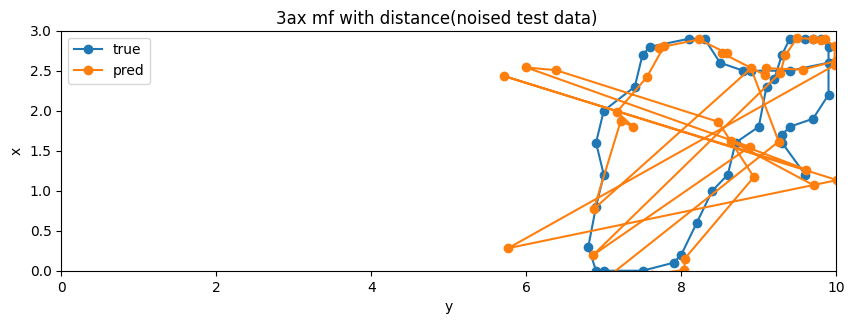

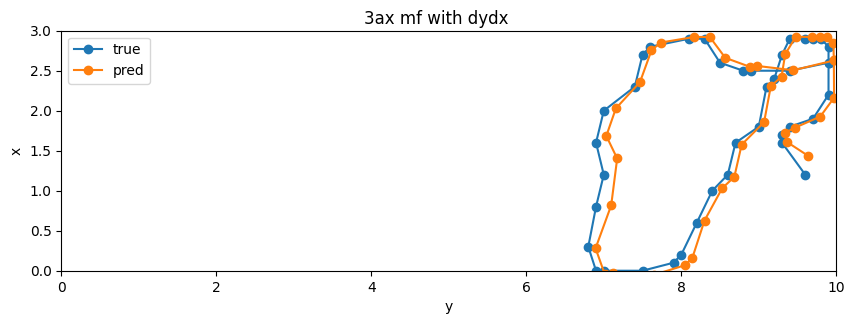

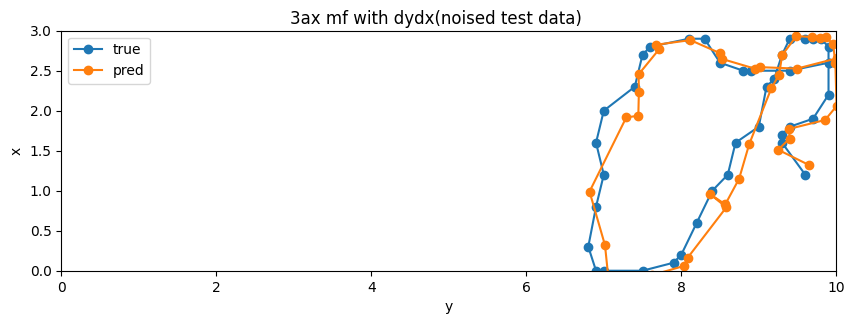

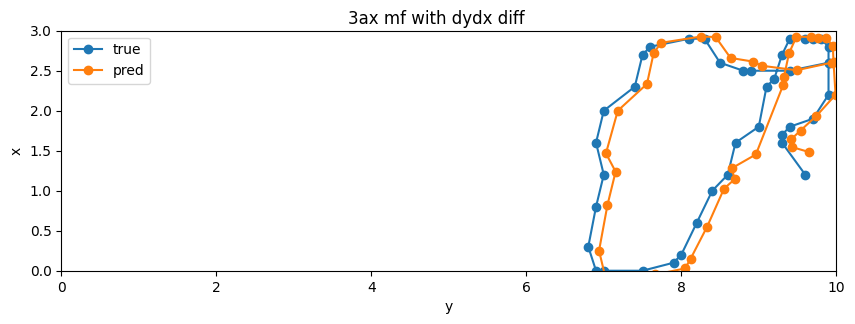

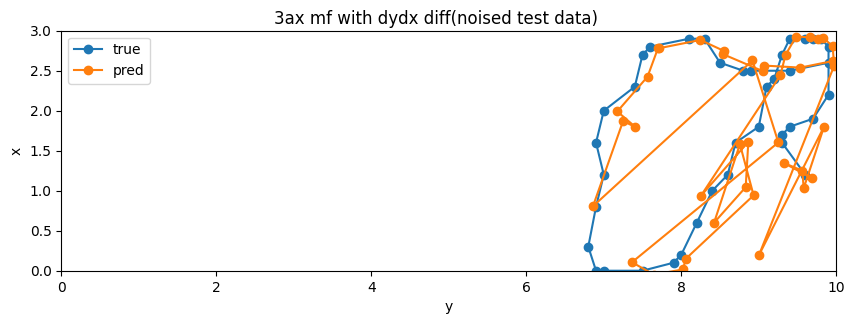

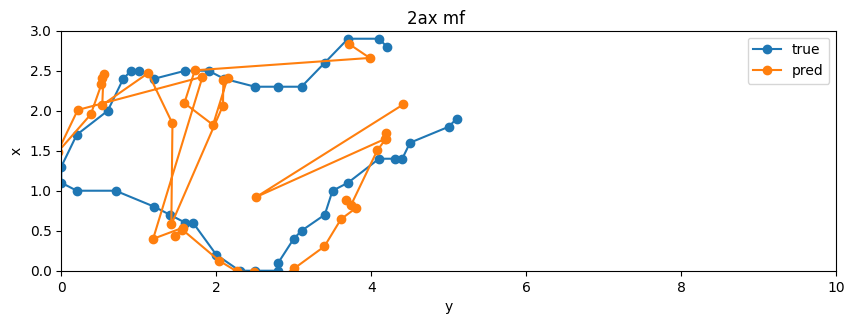

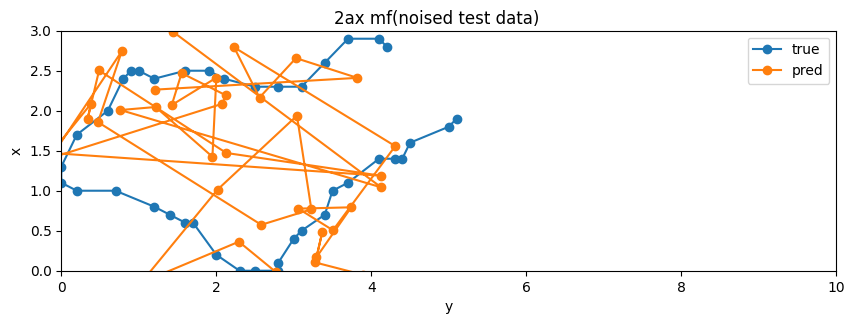

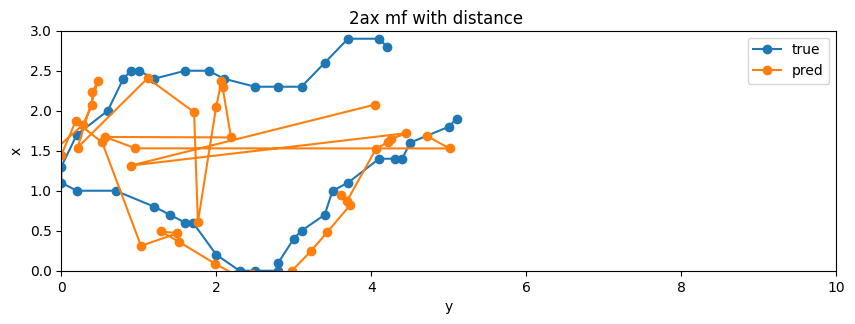

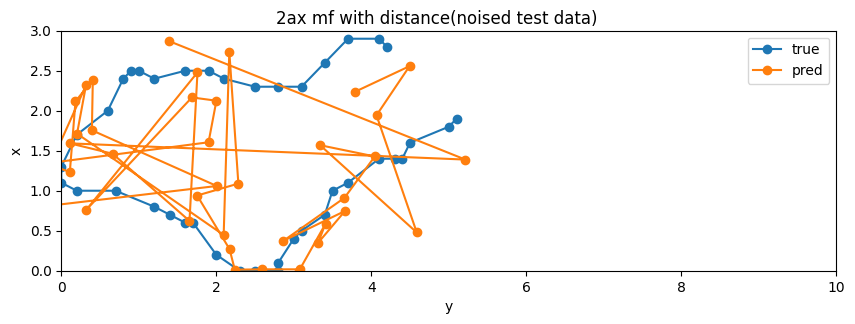

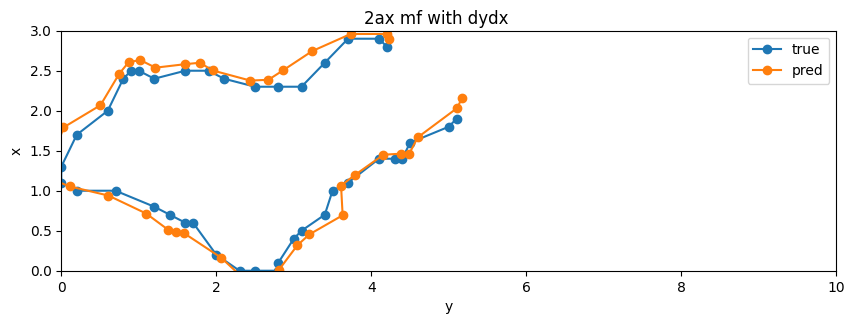

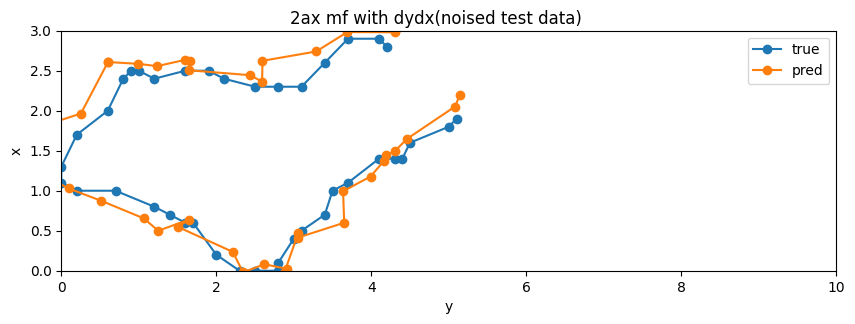

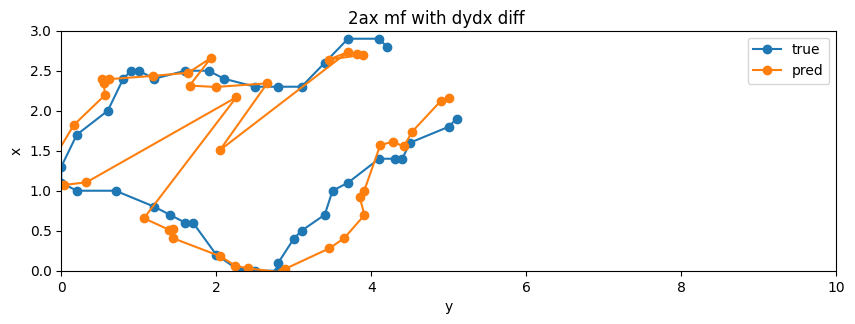

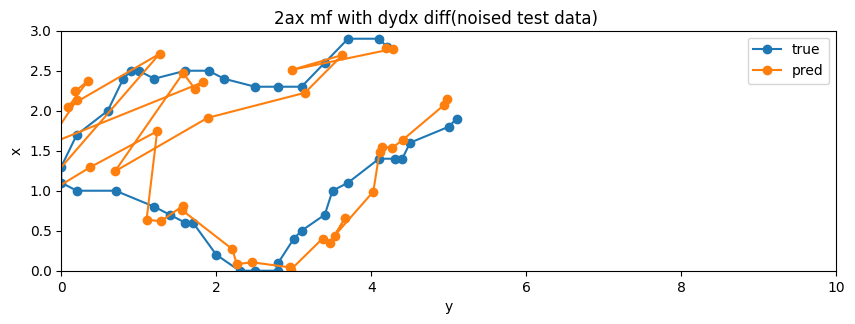

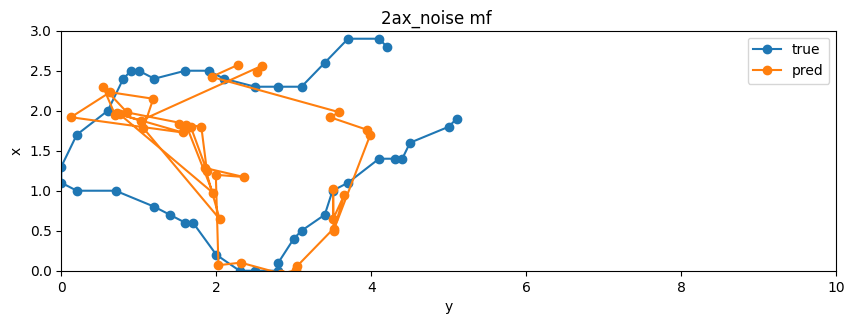

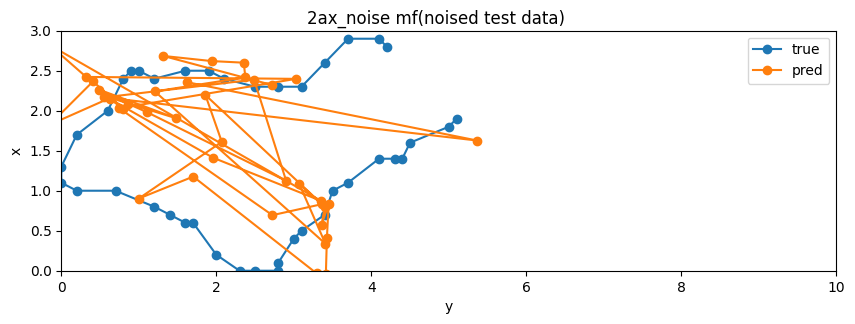

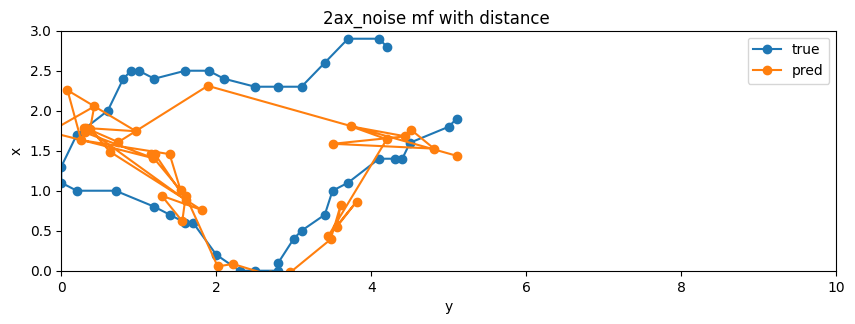

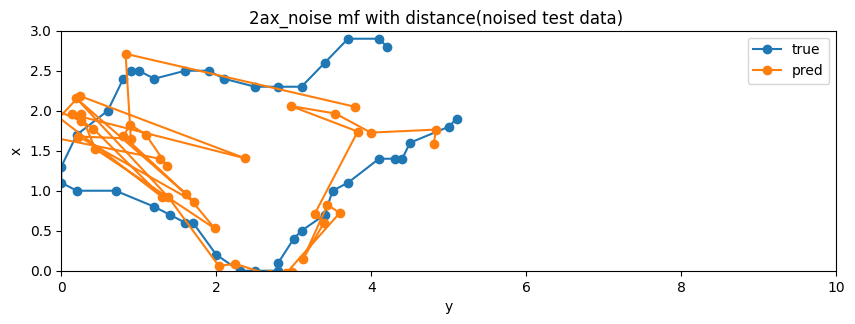

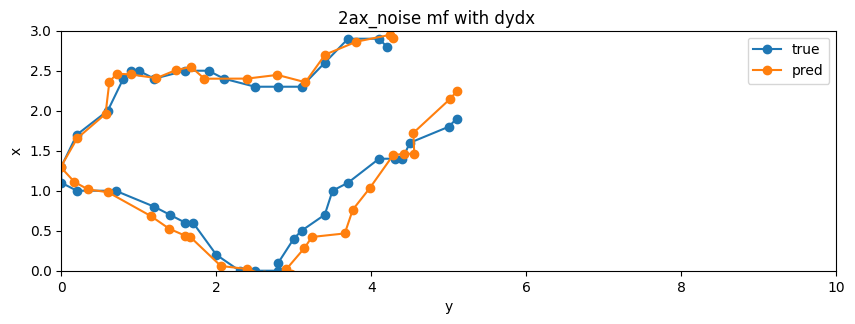

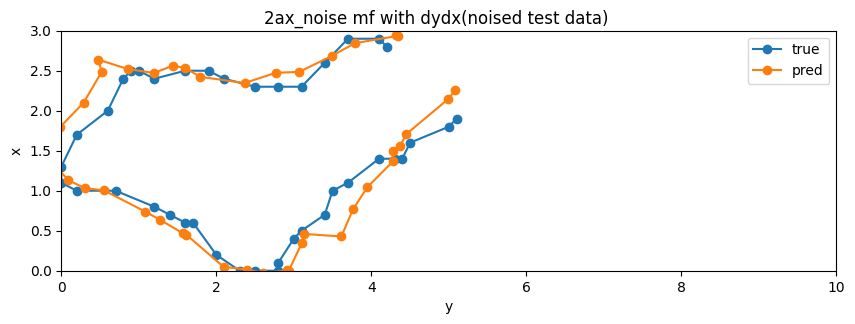

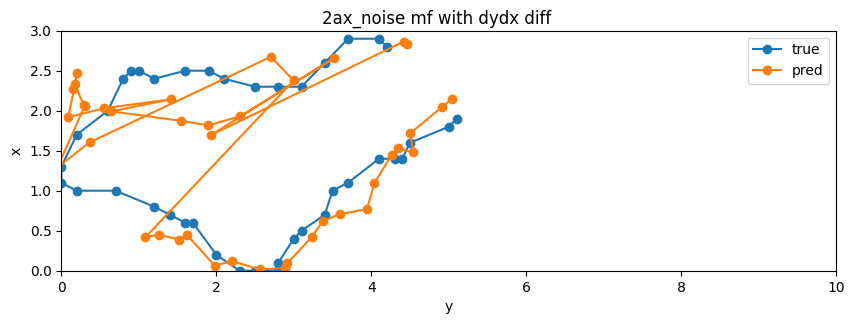

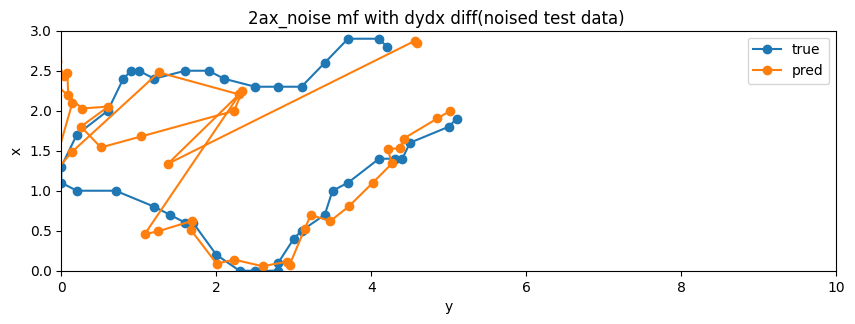

In [65]:
# titles = [
#     "predict by 2ax mf with noise",
#     "predict by 2ax mf with noise and distance",
#     "predict by 2ax mf with noise and route",
#     "predict by 2ax mf with noise and route diff",
# ]

titles = [
    "3ax mf",
    "3ax mf with distance",
    "3ax mf with dydx",
    "3ax mf with dydx diff",
    "2ax mf",
    "2ax mf with distance",
    "2ax mf with dydx",
    "2ax mf with dydx diff",
    "2ax_noise mf",
    "2ax_noise mf with distance",
    "2ax_noise mf with dydx",
    "2ax_noise mf with dydx diff",
]

# fig, ax = plt.subplots(1, 1, figsize=(10, 4))
# ax.plot(y[0, :, 1], y[0, :, 0], marker="o", label="true")
# for i, fig_data in enumerate(fig_datas):
#     x, y, y_hat = fig_data
#     figtitle = titles[i]    
#     ax.plot(y_hat[0, :, 1], y_hat[0, :, 0], marker="o", label=figtitle)

# ax.set_xlim(0, 10)
# ax.set_ylim(0, 3)
# ax.set_xlabel("y")
# ax.set_ylabel("x")
# ax.legend()
# fig.suptitle(figtitle)
# plt.tight_layout()
# plt.show()

for i in range(len(fig_datas)):
    x, y, y_hat = fig_datas[i]
    figtitle = titles[i]

    fig, ax = plt.subplots(1, 1, figsize=(10, 3))
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 3)
    fig.suptitle(figtitle)
    ax.set_xlabel("y")
    ax.set_ylabel("x")
    ax.plot(y[0, :, 1], y[0, :, 0], marker="o", label="true")
    ax.plot(y_hat[0, :, 1], y_hat[0, :, 0], marker="o", label="pred")
    ax.legend()
    plt.subplots_adjust(top=0.91)  # topの値を小さくしてタイトルを下に寄せる
    plt.show()

    x, y, y_hat = fig_datas_noise[i]
    figtitle = titles[i] + "(noised test data)"

    fig, ax = plt.subplots(1, 1, figsize=(10, 3))
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 3)
    fig.suptitle(figtitle)
    ax.set_xlabel("y")
    ax.set_ylabel("x")
    ax.plot(y[0, :, 1], y[0, :, 0], marker="o", label="true")
    ax.plot(y_hat[0, :, 1], y_hat[0, :, 0], marker="o", label="pred")
    ax.legend()
    plt.subplots_adjust(top=0.91)  # topの値を小さくしてタイトルを下に寄せる
    plt.show()